<a href="https://colab.research.google.com/github/FabianoVeglianti/Architecture_Selection_Using_Infinite_Width_Limit_Neural_Network/blob/main/simulazioni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from tensorflow_probability import math as tfmath

In [ ]:
import tensorflow as tf
import numpy as np
from numpy.random import Generator
from matplotlib import pyplot as plt
import math
import pandas as pd
from argparse import Namespace
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from google.colab import files
from scipy.stats import norm, gmean
import time
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
args = Namespace(
    # Data and Path information
    n_sample = 2000,
    d = 10, #n_0
    n_L_plus_1 = 1,
    significance = 0.05, #pvalue
    percentage_interval = 0.2   #backtesting
)

# Tools

## MLP

In [ ]:
class MLP(tf.keras.Sequential):
  def __init__(self, L, n_list, activation, Cb, Cw, seed = 100, use_bias = True, use_generator_init = False):
    """
    Args:
      use_bias (bool): attiva/disattiva l'uso dei bias nei layers
      use_generator_init (bool):
        se False usa l'inizializzazione di Gianluca
        se True usa l'inizializzazione descritta in Delving Deep into Rectifiers
    """

    super().__init__()
    self.generator = np.random.default_rng(seed)
    self.L = L
    self.n_list = n_list
    self.activation = activation
    self.Cb = Cb
    self.Cw = Cw

    index = 0
    seeds_needed = L + 1
    if use_bias == True and use_generator_init == False:
      seeds_needed += 1
    seeds = self.generator.integers(1,1000000, size=seeds_needed)

    #Creo gli inizializzatori -> oggetti necessari a inizializzare i pesi W (chiamati kernel) e i bias
    kernel_initializers_list = []
    if use_generator_init:
      kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(1/n_list[0]), seed = seeds[index]))
      index += 1
    else:
      kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(Cw/n_list[0]), seed = seeds[index]))
      index += 1

    for l in range(1, L):
      if use_generator_init:
        kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(2/n_list[l]), seed = seeds[index]))
        index += 1
      else:
        kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(Cw/n_list[l]), seed = seeds[index]))
        index += 1

    if use_generator_init:
      kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(2/n_list[L]), seed = seeds[index]))
      index +=1
    else:
      kernel_initializers_list.append(tf.keras.initializers.RandomNormal(0, math.sqrt(Cw/n_list[L]), seed = seeds[index]))
      index += 1

    bias_initializer = tf.keras.initializers.RandomNormal(stddev=math.sqrt(Cb), seed = seeds[index])


    #Aggiungo gli strati al modello: Dense e' il classico strato pieno di neuroni
    self.add(tf.keras.layers.Dense(n_list[1], input_shape=[n_list[0]], use_bias = use_bias, kernel_initializer = kernel_initializers_list[0],
              bias_initializer = bias_initializer))
    for l in range(1, L):
        self.add(tf.keras.layers.Dense(n_list[l+1], activation=activation, use_bias = use_bias, kernel_initializer = kernel_initializers_list[l],
                  bias_initializer = bias_initializer))
    self.add(tf.keras.layers.Dense(n_list[L+1], use_bias = use_bias, kernel_initializer = kernel_initializers_list[L],
                  bias_initializer = bias_initializer))
    #print("Created MLP")
    #print(self.summary())


In [ ]:
def create_constant_widths_list(L,n):
  """
  Creates a list of values representing the widths of layers of a neural network.
  All widths are the same except for the first and the last.
  Args:
    L (int): number of hidden layers
    n (int): starting value
  Returns:
    layer_widths ([int, int ...]): list of layer widths. Input layer and output layer widths are args.d and args.n_L_plus_1
      for the hidden layers the widths are computed using h_i(n) = n forall i
  """
  layer_widths = []
  layer_widths.append(args.d)
  for l in range(L):
    layer_widths.append(n)
  layer_widths.append(args.n_L_plus_1)
  return layer_widths


## DatasetHandler

In [ ]:

class DatasetHandler():
  """
  list of (possible) class attributes:
    generator
    self.mlp_generator_L
    self.mlp_generator_activation
    self.mlp_generator_Cb
    self.mlp_generator_Cw
    self.y_mean
    self.is_centered
    self.dataset

  list of class methods:
    create_dataset_from_MLP
    create_dataset_from_MLP_given_input
    create_input
    download_dataset_description
    get_dataset_description_as_dataframe
    get_dataset_with_gaussian_limit
    get_max_norm_X
    get_uncentered_dataset
    get_x1_as_array
    get_x2_as_array
    get_y_as_array
    get_y_stddev
    reset_scaled_X
    save_dataset_description_on_cloud
    set_dataset
    set_generator_params
    set_max_norm_X_to_1
  """

  def __init__(self, seed = 147):
    self.generator = np.random.default_rng(seed)

  #method
  def create_dataset_from_MLP(self, mlp, seed = 147, add_noise = False, noise = [], centered = True):
    """
    Args:
      n_sample (int): number of sample in the output dataset
      mlp (MLP): y_i = mlp(x_i)
      seed (int): seed of the PRNG
      add_noise (bool): flag for noise
      noise: ([float,float,...]): noise values
      centered: (bool): flag for centered dataset
    Returns:
      dataset (pd.Dataframe): a dataset of shape (n_sample, d + 1)
      y_mean (float): mean value if centered is set to True
    """
    self.mlp_generator_L = mlp.L
    self.mlp_generator_activation = mlp.activation
    self.mlp_generator_n_list = mlp.n_list
    self.mlp_generator_Cb = mlp.Cb
    self.mlp_generator_Cw = mlp.Cw
    self.centered = centered


    #np.random.seed = seed
    #print(np.random.seed)

    X = self.generator.uniform(low = -6.0, high = 6.0, size = (args.n_sample, args.d))
    #for i in range(X.shape[0]):
    #  X[i] = X[i]/np.linalg.norm(X[i], ord=2)

    y = mlp(X).numpy().reshape((args.n_sample))

    if add_noise:
      if len(noise) == 0:
        noise = self.generator.normal(args.noise_mean, args.noise_std, size = (args.n_sample))
      else:
        noise = np.array(noise)
      y = y + noise
    if centered:
      y_mean = np.mean(y)
      self.y_mean = y_mean
      y = y-self.y_mean
    else:
      y_mean = None

    data = {}
    for i in range(args.d):
      name_feature = "x" + str(i+1)
      data[name_feature] = X[:,i]
    data['y'] = y
    dataset = pd.DataFrame.from_dict(data)

    self.dataset = dataset
    return dataset, y_mean

  #method
  def create_dataset_from_MLP_given_input(self, mlp, input, add_noise = False, noise = [], centered = True):
    self.mlp_generator_L = mlp.L
    self.mlp_generator_activation = mlp.activation
    self.mlp_generator_n_list = mlp.n_list
    self.mlp_generator_Cb = mlp.Cb
    self.mlp_generator_Cw = mlp.Cw
    self.centered = centered
    X = input.to_numpy()

    y = mlp(X).numpy().reshape((-1))

    if add_noise:
      if len(noise) == 0:
        noise = self.generator.normal(args.noise_mean, args.noise_std, size = (args.n_sample))
      else:
        noise = np.array(noise)
      y = y + noise
    if centered:
      y_mean = np.mean(y)
      self.y_mean = y_mean
      y = y-self.y_mean
    else:
      y_mean = None

    data = {}
    for i in range(args.d):
      name_feature = "x" + str(i+1)
      data[name_feature] = X[:,i]
    data['y'] = y

    dataset = pd.DataFrame.from_dict(data)

    self.dataset = dataset
    return dataset, y_mean

  #method
  def create_input(self):
    X = self.generator.uniform(low = -6.0, high = 6.0, size = (args.n_sample, args.d))

    input_dict = {}
    for i in range(args.d):
      name_feature = "x" + str(i+1)
      input_dict[name_feature] = X[:,i]

    input_df = pd.DataFrame.from_dict(input_dict)
    return input_df


  def create_input_in_hypersphere(self, radius):
    """
    Dato il raggio (radius) genera args.n_sample punti nella ipersfera di dimensione
    args.d centrata nell'origine.
    RATIONALE: https://math.stackexchange.com/questions/87230/picking-random-points-in-the-volume-of-sphere-with-uniform-probability/87238#87238
    """
    U = self.generator.uniform(low = 0, high = 1, size = (args.n_sample, 1))
    X = self.generator.normal(loc = 0, scale = 1, size = (args.n_sample, args.d))
    norm_X = np.linalg.norm(X, ord=2, axis = 1).reshape(-1,1)

    within_sphere_X = radius * U ** (1/args.d) * X / norm_X

    input_dict = {}
    for i in range(args.d):
      name_feature = "x" + str(i+1)
      input_dict[name_feature] = within_sphere_X[:,i]

    input_df = pd.DataFrame.from_dict(input_dict)
    return input_df


  #method
  def download_dataset_description(self):
    try:
      L = getattr(self, "mlp_generator_L")
      df = self.get_dataset_description_as_dataframe()
      activation = self.mlp_generator_activation
      n = self.mlp_generator_n_list[1]
      Cb = self.mlp_generator_Cb
      Cw = self.mlp_generator_Cw
      filename = ""
      filename += activation
      filename += "_" + str(L)
      filename += "_"+str(n)
      filename += "_"+str(Cb)
      filename += "_"+str(Cw)+"_dataset_description.csv"
      df.to_csv(filename, index=False)
      files.download(filename)
    except AttributeError:
      print("You have to call create_dataset_from_MLP before trying downloading.")

  #method
  def get_dataset_description_as_dataframe(self):
    y = self.get_y_as_array(self.dataset)
    if self.centered:
      y = y + self.y_mean
    y_mean = np.mean(y)
    y_var = np.var(y)
    df = pd.DataFrame(columns=['activation', 'L', 'n', 'Cb', 'Cw', 'y_mean', 'y_var'])
    df.loc[len(df.index)] = [self.mlp_generator_activation, self.mlp_generator_L,
                             self.mlp_generator_n_list[1], self.mlp_generator_Cb,
                             self.mlp_generator_Cw, y_mean, y_var]
    return df

  #method
  def get_dataset_with_gaussian_limit(self, mlp, input = None, scaled_input = None, use_scaled_input = False):
    #new_df = pd.DataFrame(columns=['x1', 'x2', 'L', 'activation', 'Cb', 'Cw', 'gaussian_limit_var', 'gaussian_limit_std'])
    new_df_rows =[]


    for index, row in input.iterrows():
      new_row = {}
      if use_scaled_input:
        x = (scaled_input.iloc[index]).to_numpy()
      else:
        x = (row[:]).to_numpy()
      new_row = (input.iloc[index]).to_dict()
      gaussian_limit_std = get_gaussian_limit_stddev_(mlp, x)
      gaussian_limit_var = gaussian_limit_std * gaussian_limit_std
      new_row['L'] = mlp.L
      new_row['activation'] = mlp.activation
      new_row['Cb'] = mlp.Cb
      new_row['Cw'] = mlp.Cw
      new_row['gaussian_limit_var'] = gaussian_limit_var
      new_row['gaussian_limit_std'] = gaussian_limit_std
      new_df_rows.append(new_row)
    new_df = pd.DataFrame(new_df_rows)
    return new_df

  #method
  def get_max_norm_X(self, dataset):
    columns = []
    for i in range(args.d):
      columns.append('x'+str(i+1))
    X = dataset[columns]
    max_norm_X = np.max(np.linalg.norm(X, ord=2, axis =1))
    return max_norm_X

  #method
  def get_uncentered_dataset(self):
    new_df = self.dataset.copy()
    if self.centered:
      return new_df
    else:
      y = self.get_y_as_array(new_df)
      y = y + self.y_mean
      new_df = new_df.assign(y=y)
      return new_df

  #method
  def get_x1_as_array(self, dataset):
    """
    Args:
      dataset (pd.Dataframe): a dataset with column names [x1, x2, y]
    Returns:
      x1 (np.ndarray): the first column of dataset
    """
    return dataset.x1.to_numpy()

  #method
  def get_x2_as_array(self, dataset):
    """
    Args:
      dataset (pd.Dataframe): a dataset with column names [x1, x2, y]
    Returns:
      x2 (np.ndarray): the second column of dataset
    """
    return dataset.x2.to_numpy()

  #method
  def get_y_as_array(self, dataset):
    """
    Args:
      dataset (pd.Dataframe): a dataset with column names [x1, x2, y]
    Returns:
      y (np.ndarray): the last column of dataset
    """
    return dataset.y.to_numpy()

  #method
  def get_y_stddev(self):
    y = self.get_y_as_array(self.dataset)
    if self.centered:
      y = y + self.y_mean
    return np.sqrt(np.var(y))

  #method
  def reset_scaled_X(self, dataset, scale_factor):
    columns = []
    for i in range(args.d):
      columns.append('x'+str(i+1))
    X = dataset[columns]
    X = X * 1 / scale_factor
    dataset[columns] = X
    return dataset

  #method
  def save_dataset_description_on_cloud(self, basepath):
    try:
      L = getattr(self, "mlp_generator_L")
      df = self.get_dataset_description_as_dataframe()
      activation = self.mlp_generator_activation
      n = self.mlp_generator_n_list[1]
      Cb = self.mlp_generator_Cb
      Cw = self.mlp_generator_Cw
      path = basepath + str(L) + "_" + activation
      handle_dirs(path)
      filename = path + "/description.csv"
      with open(filename, 'w', encoding = 'utf-8-sig') as f:
        df.to_csv(f, index = False)
    except AttributeError:
      print("You have to call create_dataset_from_MLP before trying downloading.")

  #method
  def set_dataset(self, dataset, to_center): #da settare anche L, n, activation, Cb, Cw e centered
    if to_center:
      self.centered = True
      y = self.get_y_as_array(dataset)
      self.y_mean = np.mean(y)
      y = y - self.y_mean
      dataset = dataset.assign(y=y)
    self.dataset = dataset

  #method
  def set_generator_params(self, L, activation,Cb,Cw):
    self.mlp_generator_L = L
    self.mlp_generator_activation = activation
    self.mlp_generator_Cb = Cb
    self.mlp_generator_Cw = Cw

  #method
  def set_max_norm_X_to_val(self, dataset, val):
    new_dataset = dataset.copy()
    columns = []
    for i in range(args.d):
      columns.append('x'+str(i+1))
    X = new_dataset[columns]
    max_norm_X = np.max(np.linalg.norm(X, ord=2, axis =1))
    scale_factor = val / max_norm_X
    X = X * scale_factor
    new_dataset[columns] = X
    return new_dataset, scale_factor

In [ ]:
def scatterplot3d_from_dataset(dataset, out_filename, dataset_handler):
  #usable only if dataset has columns ['x1', 'x2', 'y']
  x1 = dataset_handler.get_x1_as_array(dataset)
  x2 = dataset_handler.get_x2_as_array(dataset)
  y = dataset_handler.get_y_as_array(dataset)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection = '3d')   # 3d projection


  pnt3d=ax.scatter(x1, x2, y, c=y)
  ax.set_xlabel('x1')                         # axis label
  ax.set_ylabel('x2')
  #ax.set_zlabel('y')
  ax.zaxis.set_ticklabels([])
  cbar=plt.colorbar(pnt3d)
  #plt.savefig(out_filename)
  plt.show()

#### TestPlotting

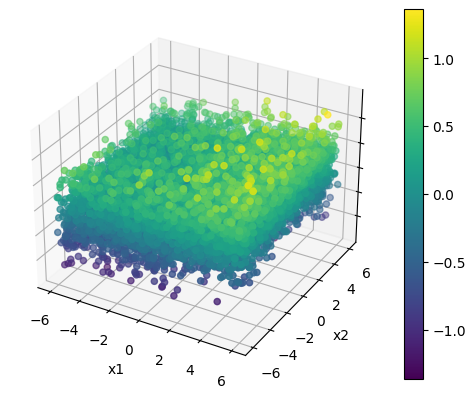

In [ ]:
dataset_handler = DatasetHandler()
L = 5
width_list = create_constant_widths_list(L, 100)
mlp = MLP(L, width_list, "relu", 1, 1, seed = 100)
dataset, _ = dataset_handler.create_dataset_from_MLP(mlp, seed = 147)
scatterplot3d_from_dataset(dataset, "", dataset_handler)



(array([   9.,   88.,  453., 1583., 2833., 2897., 1586.,  457.,   80.,
          14.]),
 array([-1.36087799e+00, -1.08864725e+00, -8.16416383e-01, -5.44185638e-01,
        -2.71954834e-01,  2.75969505e-04,  2.72506773e-01,  5.44737577e-01,
         8.16968322e-01,  1.08919919e+00,  1.36142993e+00]),
 <BarContainer object of 10 artists>)

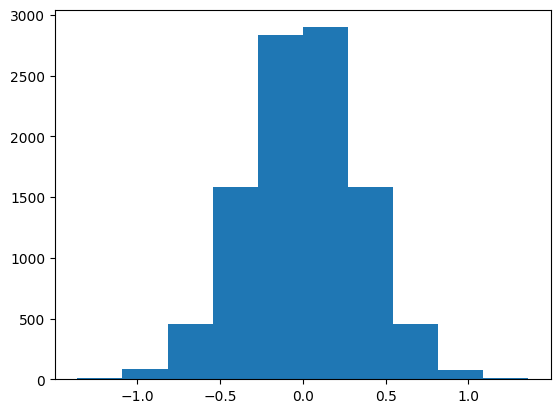

In [ ]:
fig = plt.figure()
plt.hist(dataset.y)

## Infinite Width MLP Variance Computing

In [ ]:
vZ = np.arange(start = -10,stop = 10, step = 0.001)
vProb = tf.convert_to_tensor([norm.pdf(vZ[i]) for i in range(vZ.size)], dtype = tf.float32)
vZ = tf.convert_to_tensor(vZ, dtype = tf.float32)

def numerical_integration(vZ, vActiv, vProb):
  vF = np.multiply(vActiv, vProb)
  vH = np.diff(vZ)
  nPoints = vF.size
  dInteg_rectangle = np.sum(np.multiply(vF[1:nPoints],vH))
  return dInteg_rectangle

def get_gaussian_limit_stddev_(mlp, x):
  L = mlp.L
  Cb = mlp.Cb
  Cw = mlp.Cw
  if mlp.activation == 'relu':
    #print("relu")

    CollObs_0 = 1/mlp.n_list[0]*np.square(np.linalg.norm(x, ord=2))
    if Cw == 2:
      CollObs_L = Cb/2*L + CollObs_0
    else:
      CollObs_L = Cb/2*(1-math.pow((Cw/2), L))/(1-(Cw/2)) + math.pow(Cw/2, L)*CollObs_0
    var = Cb + Cw*CollObs_L
    #print("{}->{}".format(L, var))
    return np.sqrt(var)
  else:
    L = mlp.L
    Cb = mlp.Cb
    Cw = mlp.Cw
    #print(mlp.activation)
    activation_function = tf.keras.activations.get(mlp.activation)
    #input = tf.math.multiply(vZ, dC)
    f = lambda dC: tf.multiply(tf.math.square(activation_function(tf.math.multiply(vZ,dC))), vProb)

    #vZ = np.arange(start = -10,stop = 10, step = 0.001)

    #vProb = np.array([norm.pdf(vZ[i]) for i in range(vZ.size)])

    CollObs_0 = 1/mlp.n_list[0]*tf.math.square(tf.convert_to_tensor(np.linalg.norm(x, ord=2), dtype = tf.float32))
    dC = tf.math.sqrt(Cb + Cw*CollObs_0)
    CollObs_vec = []
    CollObs_vec.append(CollObs_0)


    for j in range(1, L+1):
      res = tfmath.trapz(f(dC), vZ)
      CollObs_vec.append(tfmath.trapz(f(dC), vZ))
      dC = tf.math.sqrt(Cb + Cw*CollObs_vec[j])

    return dC.numpy()



In [ ]:
# Quando si possiede già un dataframe (df) con le varianze per ciascun x e ciascun mlp, si cerca
# nel dataframe anziché ricalcolarla.
def get_gaussian_limit_std_from_df(df, x, mlp):
  cond_L = df['L'] == mlp.L
  cond_activation = df['activation'] == mlp.activation
  cond_Cb = df['Cb'] == mlp.Cb
  cond_Cw = df['Cw'] == mlp.Cw
  cond = cond_L & cond_activation & cond_Cb & cond_Cw
  df_current_predictor = df[cond]

  columns_to_exclude = ['L', 'activation', 'Cb', 'Cw', 'gaussian_limit_var', 'gaussian_limit_std']
  all_columns = df_current_predictor.columns
  columns_to_select = [col for col in all_columns if col not in columns_to_exclude]
  dataset_cond = df_current_predictor[columns_to_select] == x
  cond = np.array([True for _ in range(dataset_cond.shape[0])])
  for i in range(dataset_cond.shape[1]):
    cond = cond & dataset_cond[dataset_cond.columns[i]]

  gaussian_limit_std = (df_current_predictor[cond]).gaussian_limit_std
  return gaussian_limit_std

## ScoreHandler

In [ ]:
class Score_Handler:
  """
  list of class methods:
    _compute_backtesting
    _compute_cdfs
    _compute_gmean
    _compute_max
    _compute_median
    _compute_min
    _compute_nloglike
    _compute_pdfs
    _compute_pvalues_vector
    _compute_quantile
    compute_all_scores
    compute_comulative_pvalue
    compute_dataset_gmean
    compute_dataset_max
    compute_dataset_median
    compute_dataset_min
    compute_dataset_nloglike
    compute_dataset_quantile
    get_grid_backtesting
    get_grid_probabilities
    get_grid_pvalues
    prepare_output_dataset
  """

  def _compute_backtesting(self, dataset, mlp, gaussian_limit_df):
    counter = 0
    M = len(dataset.index)

    for index, row in dataset.iterrows():
      y = np.array(row.y)
      x = (row[:-1]).to_numpy()
      gaussian_limit_std = get_gaussian_limit_std_from_df(gaussian_limit_df, x, mlp)

      left_percentage_bound = 0.5 - args.percentage_interval/2.0
      right_percentage_bound = 0.5 + args.percentage_interval/2.0
      left_bound = norm.ppf(left_percentage_bound, loc = 0, scale = gaussian_limit_std)
      right_bound = norm.ppf(right_percentage_bound, loc = 0, scale = gaussian_limit_std)
      #since the distribution is gaussian left_bound = -1 * right_bound

      if (y < left_bound) or (y > right_bound):
        counter += 1
    return counter / M * 100

  #method
  def _compute_cdfs(self,dataset, mlp, neighborhood_width, gaussian_limit_df):
    probabilities = []
    for _, row in dataset.iterrows():
      x = (row[:-1]).to_numpy()
      gaussian_limit_stddev = get_gaussian_limit_std_from_df(gaussian_limit_df, x, mlp)
      neighborhood = [row.y - neighborhood_width, row.y + neighborhood_width]
      probabilities.append(norm.cdf(neighborhood[1], loc = 0, scale = gaussian_limit_stddev) - \
                          norm.cdf(neighborhood[0], loc = 0, scale = gaussian_limit_stddev))
    return probabilities

  #method
  def _compute_gmean(self, list_values):
    values = np.array(list_values)
    return gmean(values)

  #method
  def _compute_max(self, list_values):
    return np.array(list_values).max()

  #method
  def _compute_median(self, list_values):
    return self._compute_quantile(list_values, q = 0.5)

  #method
  def _compute_min(self, list_values):
    return np.array(list_values).min()

  #method
  def _compute_nloglike(self, list_values):
    values = np.array(list_values)
    return (-1)*np.log(values+1e-8).mean()

  #method
  def _compute_pdfs(self,dataset, mlp, gaussian_limit_df):
    probabilities = []
    for index, row in dataset.iterrows():
      x = (row[:-1]).to_numpy()
      gaussian_limit_stddev = get_gaussian_limit_std_from_df(gaussian_limit_df, x, mlp)
      probabilities.append(norm.pdf(row.y, loc = 0, scale = gaussian_limit_stddev))
    return probabilities

  #method
  def _compute_pvalues_vector(self,dataset, mlp, gaussian_limit_df):
    pvalues = []
    for _, row in dataset.iterrows():
      #x = create_jnp_x_vector(row.x1, row.x2)
      x = (row[:-1]).to_numpy()
      y = np.array(row.y)
      gaussian_limit_stddev = get_gaussian_limit_std_from_df(gaussian_limit_df, x, mlp)
      phi_y = norm.cdf(abs(y), loc = 0, scale = gaussian_limit_stddev)
      pvalues.append(2 - 2 * phi_y)
    return np.array(pvalues)

  #method
  def _compute_quantile(self, list_values, q):
    if q < 0 or q > 1:
      print("Use q in [0,1]!")
      return None
    else:
      values = np.array(list_values)
      return np.quantile(values, q = q)

  #method
  def compute_all_scores(self, dataset_handler, grid_parameters_predictors, gaussian_limit_df, args_scores):
    output_dataset = self.prepare_output_dataset(grid_parameters_predictors)

    if args_scores.max or args_scores.min or args_scores.median:
      current_dataset_cdfs = self.get_grid_probabilities(dataset_handler, grid_parameters_predictors, gaussian_limit_df, pdf = False)

    if args_scores.nloglike or args_scores.gmean:
      current_dataset_pdfs = self.get_grid_probabilities(dataset_handler, grid_parameters_predictors, gaussian_limit_df, pdf = True)
    if args_scores.nloglike:
      nloglike_list = []
      for _, row in output_dataset.iterrows():
        L = row.L
        activation = row.activation
        Cb = row.Cb
        Cw = row.Cw
        key = (L, activation, Cb, Cw)


        nloglike = self._compute_nloglike(current_dataset_pdfs[key])
        nloglike_list.append(nloglike)
      output_dataset['nloglike'] = nloglike_list

    if args_scores.gmean:
      gmean_list = []
      for _, row in output_dataset.iterrows():
        L = row.L
        activation = row.activation
        Cb = row.Cb
        Cw = row.Cb
        key = (L, activation, Cb, Cw)
        gmean = self._compute_gmean(current_dataset_pdfs[key])
        gmean_list.append(gmean)
      output_dataset['gmean'] = gmean_list

    if args_scores.max:
      max_list = []
      for _, row in output_dataset.iterrows():
        L = row.L
        activation = row.activation
        Cb = row.Cb
        Cw = row.Cb
        key = (L, activation, Cb, Cw)
        max = self._compute_max(current_dataset_cdfs[key])
        max_list.append(max)
      output_dataset['max'] = max_list

    if args_scores.min:
      min_list = []
      for _, row in output_dataset.iterrows():
        L = row.L
        activation = row.activation
        Cb = row.Cb
        Cw = row.Cb
        key = (L, activation, Cb, Cw)
        min = self._compute_min(current_dataset_cdfs[key])
        min_list.append(min)
      output_dataset['min'] = min_list

    if args_scores.median:
      median_list = []
      for _, row in output_dataset.iterrows():
        L = row.L
        activation = row.activation
        Cb = row.Cb
        Cw = row.Cb
        key = (L, activation, Cb, Cw)
        median = self._compute_median(current_dataset_cdfs[key])
        median_list.append(median)
      output_dataset['median'] = median_list

    #print("backtesting")
    #print(current_dataset_backtesting)
    if args_scores.pvalue_comulative:
      current_dataset_pvalues = self.get_grid_pvalues(dataset_handler, grid_parameters_predictors, gaussian_limit_df)
      pvalue_comulative_scores = []
      for _, row in output_dataset.iterrows():
        L = row.L
        activation = row.activation
        Cb = row.Cb
        Cw = row.Cw
        architecture = (L, activation, Cb, Cw)
        pvalue_comulative_score = self.compute_comulative_pvalue(current_dataset_pvalues[architecture])
        #print(current_dataset_pvalues[architecture])
        #print(pvalue_comulative_score)
        pvalue_comulative_scores.append(pvalue_comulative_score)
      output_dataset['pvalue_comulative_score'] = pvalue_comulative_scores

    if args_scores.backtesting:
      current_dataset_backtesting = self.get_grid_backtesting(dataset_handler, grid_parameters_predictors, gaussian_limit_df)
      output_dataset['backtesting'] = list(current_dataset_backtesting.values())
    return output_dataset

  #method
  def compute_comulative_pvalue(self, pvalues):
    M = pvalues.shape[0]
    pvalues = pvalues.reshape(M)
    sorted_pvalues = np.sort(pvalues)

    # NOTE: can be done via binary search
    i = 1
    while i <= M:
      if(sorted_pvalues[i-1] > i/M*args.significance):
        #aggiornare questo punto
        break
      i += 1
    return i / M * 100

  #method
  def compute_dataset_gmean(self, current_dataset_probabilities):
    output_dataset = pd.DataFrame(columns=['L', 'activation', 'gmean'])
    for key in current_dataset_probabilities:
      L = key[0]
      activation = key[1]
      gmean = self._compute_gmean(current_dataset_probabilities[key])
      output_dataset.loc[len(output_dataset.index)] = [activation, L, gmean]
    return output_dataset

  #method
  def compute_dataset_max(self, current_dataset_probabilities):
    output_dataset = pd.DataFrame(columns=['L', 'activation', 'max'])
    for key in current_dataset_probabilities:
      L = key[0]
      activation = key[1]
      max = self._compute_max(current_dataset_probabilities[key])
      output_dataset.loc[len(output_dataset.index)] = [activation, L, max]
    return output_dataset

  #method
  def compute_dataset_median(self, current_dataset_probabilities):
    output_dataset = pd.DataFrame(columns=['L', 'activation', 'median'])
    for key in current_dataset_probabilities:
      L = key[0]
      activation = key[1]
      median = self._compute_median(current_dataset_probabilities[key])
      output_dataset.loc[len(output_dataset.index)] = [activation, L, median]
    return output_dataset

  #method
  def compute_dataset_min(self, current_dataset_probabilities):
    output_dataset = pd.DataFrame(columns=['L', 'activation', 'min'])
    for key in current_dataset_probabilities:
      L = key[0]
      activation = key[1]
      min = self._compute_min(current_dataset_probabilities[key])
      output_dataset.loc[len(output_dataset.index)] = [activation, L, min]
    return output_dataset

 #method
  def compute_dataset_nloglike(self, current_dataset_probabilities):
    output_dataset = pd.DataFrame(columns=['L', 'activation', 'nloglike'])
    for key in current_dataset_probabilities:
      L = key[0]
      activation = key[1]
      nloglike = self._compute_nloglike(current_dataset_probabilities[key])
      output_dataset.loc[len(output_dataset.index)] = [activation, L, nloglike]
    return output_dataset

  #method
  def compute_dataset_quantile(self, current_dataset_probabilities, q):
    output_dataset = pd.DataFrame(columns=['L', 'activation', 'quantile'])
    for key in current_dataset_probabilities:
      L = key[0]
      activation = key[1]
      quantile = self._compute_quantile(current_dataset_probabilities[key], q)
      output_dataset.loc[len(output_dataset.index)] = [activation, L, quantile]
    return output_dataset

  #method
  def get_grid_backtesting(self,dataset_handler, grid_parameters_predictors, gaussian_limit_df):
    """ For each architecture in grid_parameters_predictors computes the backtesting"""
    current_dataset_backtesting = {}
    for L in grid_parameters_predictors['L']:
      for n in grid_parameters_predictors['n']: #it should be only one
        for activation in grid_parameters_predictors['activation']:
          for Cb in grid_parameters_predictors['Cb']:
            for Cw in grid_parameters_predictors['Cw']:
              layer_widths = create_constant_widths_list(L, n)
              mlp = MLP(L, layer_widths, activation, Cb, Cw)

              backtesting = self._compute_backtesting(dataset_handler.dataset, mlp, gaussian_limit_df)
              current_dataset_backtesting[(L, activation, Cb, Cw)] = backtesting
    return current_dataset_backtesting

  #method
  def get_grid_probabilities(self,dataset_handler, grid_parameters_predictors, gaussian_limit_df, pdf):
    """ For each architecture in grid_parameters_predictors computes the probabilities"""
    current_dataset_probabilities = {}
    for L in grid_parameters_predictors['L']:
      for n in grid_parameters_predictors['n']: #it should be only one
        for activation in grid_parameters_predictors['activation']:
          for Cb in grid_parameters_predictors['Cb']:
            for Cw in grid_parameters_predictors['Cw']:
              layer_widths = create_constant_widths_list(L, n)
              mlp = MLP(L, layer_widths, activation, Cb, Cw)
              if pdf:
                probabilities = self._compute_pdfs(dataset_handler.dataset, mlp, gaussian_limit_df)
              else:
                probabilities = self._compute_cdfs(dataset_handler.dataset, mlp, dataset_handler.get_y_stddev()/2.0, gaussian_limit_df)
              current_dataset_probabilities[(L, activation, Cb, Cw)] = probabilities
    return current_dataset_probabilities

  #method
  def get_grid_pvalues(self,dataset_handler, grid_parameters_predictors, gaussian_limit_df):
    """ For each architecture in grid_parameters_predictors computes the pvalues"""
    current_dataset_pvalues = {}
    for L in grid_parameters_predictors['L']:
      for n in grid_parameters_predictors['n']: #it should be only one
        for activation in grid_parameters_predictors['activation']:
          for Cb in grid_parameters_predictors['Cb']:
            for Cw in grid_parameters_predictors['Cw']:
              layer_widths = create_constant_widths_list(L, n)
              mlp = MLP(L, layer_widths, activation, Cb, Cw)
              pvalues = self._compute_pvalues_vector(dataset_handler.dataset, mlp, gaussian_limit_df)
              current_dataset_pvalues[(L, activation, Cb, Cw)] = pvalues
    return current_dataset_pvalues

  #method
  def prepare_output_dataset(self, grid_parameters_predictors):
    output_dataset = pd.DataFrame(columns=['L', 'activation',  'Cb', 'Cw'])
    for architecture in get_architecture(grid_parameters_predictors):
      L, _, activation, Cb, Cw = unpack_architecture(architecture)
      output_dataset.loc[len(output_dataset.index)] = [L, activation, Cb, Cw]
    return output_dataset


# Testing

Creiamo una classe per gestire i dati di una simulazione su un dataset.

In [ ]:
class MLPGeneratedDatasetSimulation:
  """ Class to collect results over 1 dataset

  list of class (possible) attributes:
    dataset_handler
    result_dataset

  list of class methods:
    create_from_csv                   @classmethod
    create_from_csv_with_results      @classmethod
    download_dataset_description
    download_dataset_results
    get_mlp_generator_hyperparameters
    get_results
    save_dataset_description_on_cloud
    save_dataset_results_on_cloud
    set_results
    set_source_dataset
  """
  def __init__(self, dataset_handler):
    self.dataset_handler = dataset_handler

  @classmethod
  def create_from_csv(cls, L, activation, Cb, Cw):
    dataset_handler = DatasetHandler()
    dataset_handler.set_generator_params(L, activation,Cb,Cw)
    return cls(dataset_handler)

  @classmethod
  def create_from_csv_with_results(cls, L, activation, Cb, Cw):
    obj = cls.create_from_csv(L, activation, Cb, Cw)

    filename = basepath+ str(L) + "_" + activation + "/scores.csv"
    with open(filename, 'r', encoding = 'utf-8-sig') as f:
      scores = pd.read_csv(f)

    obj.set_results(scores)
    return obj

  #method
  def download_dataset_description(self):
      self.dataset_handler.download_dataset_description()

  #method
  def download_dataset_results(self):
    try:
      result_dataset = getattr(self, "result_dataset")
      L = self.dataset_handler.mlp_generator_L
      activation = self.dataset_handler.mlp_generator_activation
      Cb = self.dataset_handler.mlp_generator_Cb
      Cw = self.dataset_handler.mlp_generator_Cw

      filename = ""
      filename += activation
      filename += "_" + str(L)
      filename += "_"+str(Cb)
      filename += "_"+str(Cw)+"_results.csv"
      result_dataset.to_csv(filename, index=False)
      files.download(filename)
    except AttributeError:
      print("You have to call create_dataset_from_MLP before trying downloading.")

  #method
  def get_mlp_generator_hyperparameters(self):
    return (self.dataset_handler.mlp_generator_L,
            self.dataset_handler.mlp_generator_activation,
            self.dataset_handler.mlp_generator_n,
            self.dataset_handler.mlp_generator_Cb,
            self.dataset_handler.mlp_generator_Cw)

  #method
  def get_results(self):
    try:
      result_dataset = getattr(self, "result_dataset")
      return result_dataset
    except AttributeError:
      print("You have to call set_results before trying getting.")

  #method
  def save_dataset_description_on_cloud(self, basepath):
    self.dataset_handler.save_dataset_description_on_cloud(basepath)

  #method
  def save_dataset_results_on_cloud(self, basepath):
    try:
      result_dataset = getattr(self, "result_dataset")
      L = self.dataset_handler.mlp_generator_L
      activation = self.dataset_handler.mlp_generator_activation
      Cb = self.dataset_handler.mlp_generator_Cb
      Cw = self.dataset_handler.mlp_generator_Cw
      path = basepath + str(L) + "_" + activation
      handle_dirs(path)
      filename = path + "/scores.csv"
      with open(filename, 'w', encoding = 'utf-8-sig') as f:
        result_dataset.to_csv(f, index = False)
    except AttributeError:
      print("You have to call create_dataset_from_MLP before trying downloading.")

  #method
  def set_results(self, result_dataset):
    self.result_dataset = result_dataset

  #method
  def set_source_dataset(self, dataset, to_center):
    self.dataset_handler.set_dataset(dataset, to_center)

### Plotting

lineplots crea dei lineplot che contengono lo score in funzione di L.\
 Ogni plot contiene una linea per ogni funzione di attivazione (attualemente il codice funziona solo con relu a causa dei commenti)

In [ ]:
def lineplots(list_dataset_results, basepath, args_scores):
  for mlpgenerator_datasetsimulation in list_dataset_results:
    mlp_generator_L = mlpgenerator_datasetsimulation.dataset_handler.mlp_generator_L
    mlp_generator_activation = mlpgenerator_datasetsimulation.dataset_handler.mlp_generator_activation


    path = basepath + str(mlp_generator_L) + "_" + mlp_generator_activation + "/"
    handle_dirs(path)

    current_dataset_results = mlpgenerator_datasetsimulation.result_dataset
    pred_L_list = np.array(list(set(current_dataset_results.L.to_list())))
    relu_subset = current_dataset_results.loc[current_dataset_results['activation'] == 'relu']
    #sigmoid_subset = current_dataset_results.loc[current_dataset_results['activation'] == 'sigmoid']
    #tanh_subset = current_dataset_results.loc[current_dataset_results['activation'] == 'tanh']

    if args_scores.nloglike:
      fig_nloglike = plt.figure()
      plt.plot(pred_L_list, np.log(relu_subset['nloglike'].to_numpy()),  marker='*', color = 'r', label = 'relu')
      #plt.plot(pred_L_list, np.log(sigmoid_subset['nloglike'].to_numpy()),marker='*', color = 'g', label = 'sigmoid')
      #plt.plot(pred_L_list, np.log(tanh_subset['nloglike'].to_numpy()), marker='*', color = 'b', label = 'tanh')
      plt.xlabel("L")
      plt.ylabel("nloglike")
      plt.legend()
      filename = path + "nloglike.png"
      fig_nloglike.savefig(filename)

    if args_scores.gmean:
      fig_gmean = plt.figure()
      plt.plot(pred_L_list, relu_subset['gmean'].to_numpy(),  marker='*', color = 'r', label = 'relu')
      #plt.plot(pred_L_list, sigmoid_subset['gmean'].to_numpy(),marker='*', color = 'g', label = 'sigmoid')
      #plt.plot(pred_L_list, tanh_subset['gmean'].to_numpy(), marker='*', color = 'b', label = 'tanh')
      plt.xlabel("L")
      plt.ylabel("gmean")
      plt.legend()
      filename = path + "gmean.png"
      fig_gmean.savefig(filename)

    if args_scores.pvalue_comulative:
      fig_pvalue_comulative_score = plt.figure()
      plt.plot(pred_L_list, relu_subset['pvalue_comulative_score'].to_numpy(),  marker='*', color = 'r', label = 'relu')
    # plt.plot(pred_L_list, sigmoid_subset['pvalue_comulative_score'].to_numpy(),marker='*', color = 'g', label = 'sigmoid')
      #plt.plot(pred_L_list, tanh_subset['pvalue_comulative_score'].to_numpy(), marker='*', color = 'b', label = 'tanh')
      plt.xlabel("L")
      plt.ylabel("pvalue_comulative_score")
      plt.legend()
      filename = path + "pvalue_comulative_score.png"
      fig_pvalue_comulative_score.savefig(filename)

    if args_scores.backtesting:
      fig_backtesting = plt.figure()
      plt.plot(pred_L_list, relu_subset['backtesting'].to_numpy(),  marker='*', color = 'r', label = 'relu')
    # plt.plot(pred_L_list, sigmoid_subset['backtesting'].to_numpy(),marker='*', color = 'g', label = 'sigmoid')
    # plt.plot(pred_L_list, tanh_subset['backtesting'].to_numpy(), marker='*', color = 'b', label = 'tanh')
      plt.xlabel("L")
      plt.ylabel("backtesting")
      plt.legend()
      filename = path + "backtesting.png"
      fig_backtesting.savefig(filename)

    if args_scores.median:
      fig_median = plt.figure()
      plt.plot(pred_L_list, relu_subset['median'].to_numpy(),  marker='*', color = 'r', label = 'relu')
      #plt.plot(pred_L_list, sigmoid_subset['median'].to_numpy(),marker='*', color = 'g', label = 'sigmoid')
      #plt.plot(pred_L_list, tanh_subset['median'].to_numpy(), marker='*', color = 'b', label = 'tanh')
      plt.xlabel("L")
      plt.ylabel("median")
      plt.legend()
      filename = path + "median.png"
      fig_median.savefig(filename)



### Helpers


In [ ]:
def get_num_architectures(grid_parameters_datasets):
  return len(list(grid_parameters_datasets['L'])) * len(grid_parameters_datasets['activation'])

def get_architecture(grid_parameters):
  for L in grid_parameters['L']:
    for n in grid_parameters['n']:
      for activation in grid_parameters['activation']:
        for Cb in grid_parameters['Cb']:
          for Cw in grid_parameters['Cw']:
            architecture = (L, n, activation, Cb, Cw)
            yield architecture

def unpack_architecture(architecture):
  L = architecture[0]
  n = architecture[1]
  activation = architecture[2]
  Cb = architecture[3]
  Cw = architecture[4]
  return L, n, activation, Cb, Cw

def handle_dirs(dirpath):
  if not os.path.exists(dirpath):
    print("provo a crearla")
    os.makedirs(dirpath)

In [ ]:
def compute_Cw_from_max_norm_X(max_norm_X, Cb):
  O_0_x_star = 1/args.d * max_norm_X * max_norm_X
  Cw = 2*(1-Cb/(2*O_0_x_star))
  return float(Cw)

def compute_Cw_from_var_y(var_y, Cb):
  Cw = 2 - 2*Cb/var_y
  return float(Cw)

In [ ]:
# Create or Load Input
def create_or_load_input(basepath, args_datahandling, radius = -1):
  """
  Se radius = -1 (default) allora crea i dati nell'ipercubo, altrimenti nell'ipersfera di raggio radius.
  """
  dataset_handler = DatasetHandler()
  if args_datahandling.create_new_input:
    if radius == -1:
      input = dataset_handler.create_input()
    else:
      input = dataset_handler.create_input_in_hypersphere(radius)

    if args_datahandling.save_input_on_cloud:
      handle_dirs(basepath)
      filename = basepath + "input.csv"
      with open(filename, 'w', encoding = 'utf-8-sig') as f:
        input.to_csv(f, index = False)
    return input
  else:
    filename = basepath+"input.csv"
    with open(filename, 'r', encoding = 'utf-8-sig') as f:
      input = pd.read_csv(f)
    return input


# Compute or load gaussian limit var for each predictors
def create_or_load_gaussian_limit_for_each_predictors(basepath, args_datahandling, grid_parameters_predictors,input, scaled_input = None, use_scaled_input = False):
  dataset_handler = DatasetHandler()
  if args_datahandling.compute_gaussian_limit:
    columns = []
    for i in range(args.d):
      columns.append("x" + str(i+1))
    columns.extend(['L','activation','Cb','Cw','gaussian_limit_var', 'gaussian_limit_std'])
    gaussian_limit_df = pd.DataFrame(columns=columns)
    for predictor_architectures in get_architecture(grid_parameters_predictors):
      pred_L = predictor_architectures[0]
      pred_n = predictor_architectures[1]
      pred_width_list = create_constant_widths_list(pred_L, pred_n)
      pred_activation = predictor_architectures[2]
      pred_Cb = predictor_architectures[3]
      pred_Cw = predictor_architectures[4]
      predictor = MLP(pred_L, pred_width_list, pred_activation, pred_Cb, pred_Cw, seed = 111)
      gaussian_limit_df = pd.concat([gaussian_limit_df, dataset_handler.get_dataset_with_gaussian_limit(predictor, input, scaled_input, use_scaled_input)], ignore_index=True)
    if args_datahandling.save_gaussian_limit_on_cloud:
      handle_dirs(basepath)
      filename = basepath + "gaussian_limit.csv"
      with open(filename, 'w', encoding = 'utf-8-sig') as f:
        gaussian_limit_df.to_csv(f, index = False)
    return gaussian_limit_df
  else:
    filename = basepath + "gaussian_limit.csv"
    with open(filename, 'r', encoding = 'utf-8-sig') as f:
      gaussian_limit_df = pd.read_csv(f)
    return gaussian_limit_df


Esempio di codice per ricaricare i risultati memorizzati nel cloud

(DA SISTEMARE)

In [ ]:
grid_dataset_results = []
path='/content/drive/MyDrive/Simulazioni/Simulazione_A/'
filename = path + "/gaussian_limit.csv"
with open(filename, 'r', encoding = 'utf-8-sig') as f:
  gaussian_limit_df = pd.read_csv(f)
for L in grid_parameters_datasets['L']:
  mlpgenerated_dataset_simulation = MLPGeneratedDatasetSimulation.create_from_csv_with_results(L=L, activation="relu", Cb=1, Cw=1)
  path='/content/drive/MyDrive/Simulazioni/Simulazione_A/'
  path += str(L) + "_" + "relu"
  handle_dirs(path)
  filename = path + "/dataset.csv"
  with open(filename, 'r', encoding = 'utf-8-sig') as f:
    source_dataset = pd.read_csv(f)
  mlpgenerated_dataset_simulation.set_source_dataset(source_dataset, to_center = True)


  filename = path + "/scores.csv"
  with open(filename, 'r', encoding = 'utf-8-sig') as f:
    scores_dataset = pd.read_csv(f)
  columns = scores_dataset.columns
  score_handler = Score_Handler()
  dataset_handler = DatasetHandler()

  dataset_handler.set_generator_params(L =L, activation = "relu", Cb=1, Cw=1)
  dataset_handler.set_dataset(source_dataset, to_center = True)
  grid_dataset_results.append(mlpgenerated_dataset_simulation)


### Descrizione Simulazione A
Generator: L = [5,10,15]\
Generator: activation = 'relu'\
Generator: Cw = 2\
Generator: No Bias

Predictor: L = [1,...,25]\
Predictor: activation = 'relu'\
Predictor: Cw = 1\
Predictor: Cb = 1


Viene effettuata la trasformazione \
x_ij <- x_ij / max{norm(x_i)}

In [ ]:
# Guida all'uso dei parametri:
# Alla prima esecuzione tutti i booleani devono essere posti a True
# I booleani create_new_input, save_input_on_cloud, compute_gaussian_limit e
# save_gaussian_limit_on_cloud servono a:
# (1) creare i dati di input X e memorizzarli sul cloud
# (2) calcolare per ciascun input e ciascun predittore la varianza della
#     gaussiana limite e memorizzarle sul cloud
# In caso in cui create_new_input e/o compute_gaussian_limit fossero falsi, il
# dataset corrispettivo è caricato dal cloud (quindi almeno la prima volta
# occorre crearlo)
# I booleani save_dataset_on_cloud, save_results_on_cloud e save_figures_on_cloud
# servono per abilitare/disabilitare il salvataggio del dataset (X, y), i
# risultati (predittore, scores) o le figure sul cloud.

args_datahandling = Namespace(
    create_new_input = True,
    save_input_on_cloud = True,
    compute_gaussian_limit = True,
    save_gaussian_limit_on_cloud = True,
    save_dataset_on_cloud = True,
    save_results_on_cloud = True,
    save_figures_on_cloud = True
)

# basepath è il percorso nel cloud in cui saranno salvati i risultati.
# Se basepath = '/content/drive/MyDrive/Simulazioni/Simulazione_A/'
# i risultati della simulazione A saranno salvati nella cartella Simulazioni
# sottocartella Simulazione_A
basepath = '/content/drive/MyDrive/Simulazioni/Simulazione_A/'

In [ ]:
grid_parameters_datasets = {'L' : [5,10,15], 'n':[50], 'activation':['relu'], 'Cb': [1], 'Cw': [1]}
grid_parameters_predictors = {'L' : np.arange(1,26,1), 'n':[5], 'activation':['relu'], 'Cb': [1], 'Cw': [1]}

In [ ]:
dataset_handler = DatasetHandler()
input = create_or_load_input(basepath, args_datahandling)


1/3
2/3
3/3


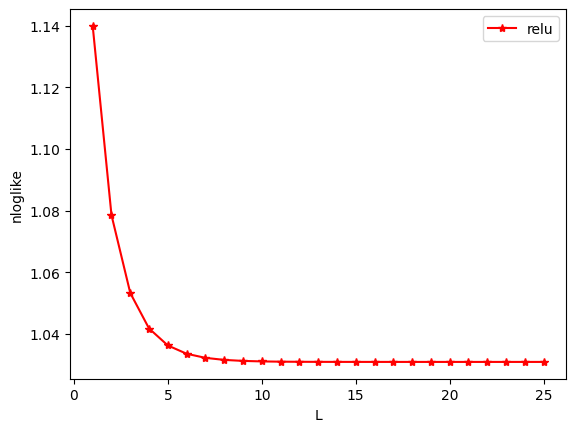

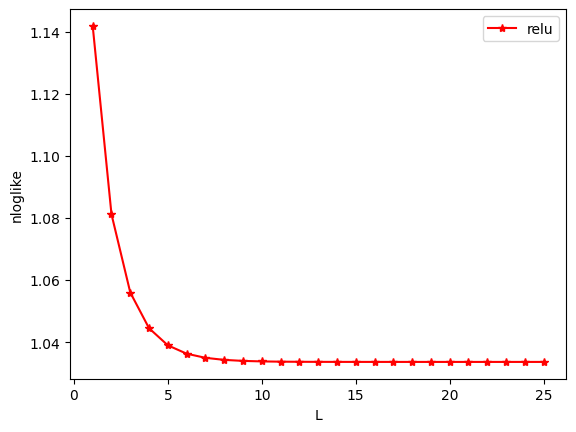

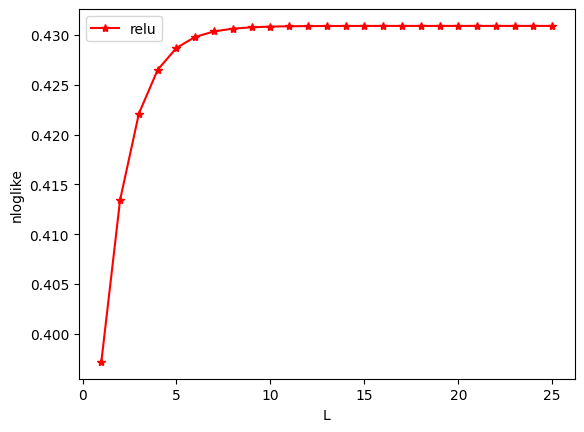

In [ ]:
args_scores = Namespace(
    nloglike = True,
    gmean = False,
    max = False,
    min = False,
    median = False,
    pvalue_comulative = False,
    backtesting = False
)

iteration_number = 0
total_iterations = len(grid_parameters_datasets['L'])*len(grid_parameters_datasets['n'])*len(grid_parameters_datasets['activation'])
grid_dataset_results = []
for architecture in get_architecture(grid_parameters_datasets):
  # print iteration_number
  iteration_number = iteration_number + 1
  print("{}/{}".format(iteration_number, total_iterations))

  dataset_handler = DatasetHandler()
  score_handler = Score_Handler()

  # Generator MLP Parameters
  L, n, activation, Cb, Cw = unpack_architecture(architecture)
  width_list = create_constant_widths_list(L, n)


  # Instantiate Generator
  mlp = MLP(L, width_list, activation, Cb, Cw, seed = L, use_bias = False, use_generator_init = True)

  # Create Dataset
  dataset, _= dataset_handler.create_dataset_from_MLP_given_input(mlp, input)
  scaled_input , max_norm_X = dataset_handler.set_max_norm_X_to_1(input)

  path = basepath + str(L) + "_" + activation + "/"
  gaussian_limit_df = create_or_load_gaussian_limit_for_each_predictors(path, args_datahandling, grid_parameters_predictors, input, scaled_input, use_scaled_input = True)



  mlpgenerator_datasetsimulation = MLPGeneratedDatasetSimulation(dataset_handler)
  if args_datahandling.save_dataset_on_cloud:
    # Save dataset description
    mlpgenerator_datasetsimulation.save_dataset_description_on_cloud(basepath)
    # Save dataset
    centered_dataset = dataset_handler.get_uncentered_dataset()
    path = basepath + str(L) + "_" + activation
    handle_dirs(path)
    filename = path + "/dataset.csv"
    with open(filename, 'w', encoding = 'utf-8-sig') as f:
      centered_dataset.to_csv(f, index = False)

  current_dataset_results = score_handler.compute_all_scores(dataset_handler, grid_parameters_predictors, gaussian_limit_df, args_scores)
  mlpgenerator_datasetsimulation.set_results(current_dataset_results)

  if args_datahandling.save_results_on_cloud:
    mlpgenerator_datasetsimulation.save_dataset_results_on_cloud(basepath)

  grid_dataset_results.append(mlpgenerator_datasetsimulation)

if args_datahandling.save_figures_on_cloud:
  lineplots(grid_dataset_results, basepath, args_scores)

### Descrizione Simulazione B
Generator: L = [5,10,15]\
Generator: activation = 'relu'\
Generator: Cw = 2\
Generator: No Bias

Predictor: L = [1,...,25]\
Predictor: activation = 'relu'\
Predictor: Cw = f(X) - attraverso compute_Cw_from_max_norm_X\
Predictor: Cb = 1




In [ ]:
# Guida all'uso dei parametri:
# Alla prima esecuzione tutti i booleani devono essere posti a True
# I booleani create_new_input, save_input_on_cloud, compute_gaussian_limit e
# save_gaussian_limit_on_cloud servono a:
# (1) creare i dati di input X e memorizzarli sul cloud
# (2) calcolare per ciascun input e ciascun predittore la varianza della
#     gaussiana limite e memorizzarle sul cloud
# In caso in cui create_new_input e/o compute_gaussian_limit fossero falsi, il
# dataset corrispettivo è caricato dal cloud (quindi almeno la prima volta
# occorre crearlo)
# I booleani save_dataset_on_cloud, save_results_on_cloud e save_figures_on_cloud
# servono per abilitare/disabilitare il salvataggio del dataset (X, y), i
# risultati (predittore, scores) o le figure sul cloud.
args_datahandling = Namespace(
    create_new_input = True,
    save_input_on_cloud = True,
    compute_gaussian_limit = True,
    save_gaussian_limit_on_cloud = True,
    save_dataset_on_cloud = True,
    save_results_on_cloud = True,
    save_figures_on_cloud = True
)

# basepath è il percorso nel cloud in cui saranno salvati i risultati.
# Se basepath = '/content/drive/MyDrive/Simulazioni/Simulazione_B/'
# i risultati della simulazione B saranno salvati nella cartella Simulazioni
# sottocartella Simulazione_B
basepath = '/content/drive/MyDrive/Simulazioni/Simulazione_B/'

In [ ]:
grid_parameters_datasets = {'L' : [5,10,15], 'n':[50], 'activation':['relu'], 'Cb': [1], 'Cw': [1]}
grid_parameters_predictors = {'L' : np.arange(1,26,1), 'n':[5], 'activation':['relu'], 'Cb': [1], 'Cw': [1]}

In [ ]:
dataset_handler = DatasetHandler()
input = create_or_load_input(basepath, args_datahandling)
max_norm_X = dataset_handler.get_max_norm_X(input)


In [ ]:
grid_parameters_predictors

{'L': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),
 'n': [5],
 'activation': ['relu'],
 'Cb': [1],
 'Cw': [1]}

1/3
2/3
3/3


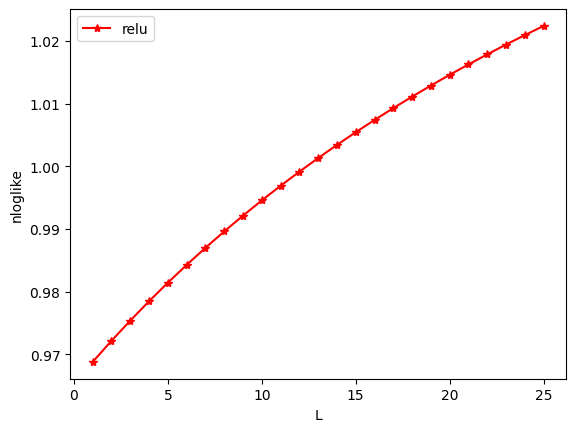

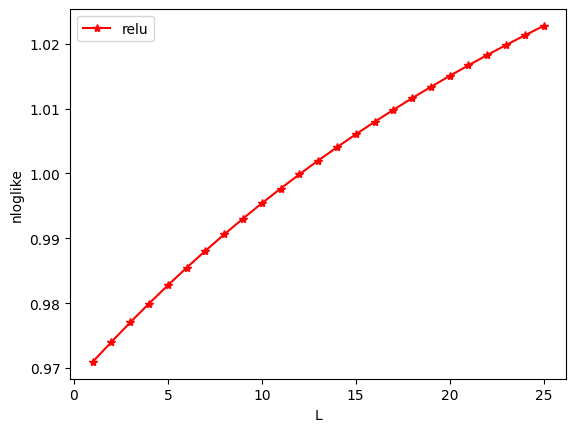

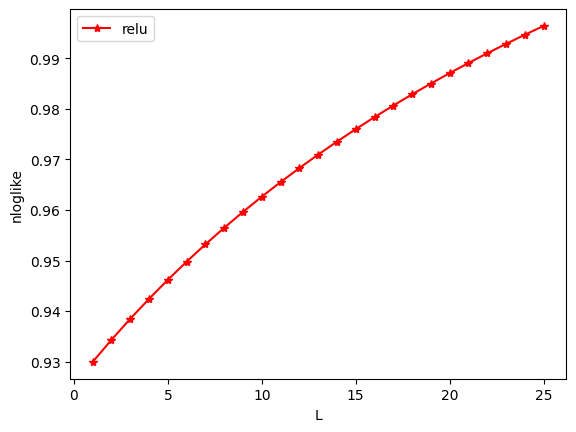

In [ ]:
args_scores = Namespace(
    nloglike = True,
    gmean = False,
    max = False,
    min = False,
    median = False,
    pvalue_comulative = False,
    backtesting = False
)

iteration_number = 0
total_iterations = len(grid_parameters_datasets['L'])*len(grid_parameters_datasets['n'])*len(grid_parameters_datasets['activation'])
grid_dataset_results = []
for architecture in get_architecture(grid_parameters_datasets):
  # print iteration_number
  iteration_number = iteration_number + 1
  print("{}/{}".format(iteration_number, total_iterations))

  dataset_handler = DatasetHandler()
  score_handler = Score_Handler()

  # Generator MLP Parameters
  L, n, activation, Cb, Cw = unpack_architecture(architecture)
  width_list = create_constant_widths_list(L, n)


  # Instantiate Generator
  mlp = MLP(L, width_list, activation, Cb, Cw, seed = L, use_bias = False, use_generator_init = True)

  # Create Dataset
  dataset, _= dataset_handler.create_dataset_from_MLP_given_input(mlp, input)

  # Set Cw according to max_norm_X
  Cw = compute_Cw_from_max_norm_X(max_norm_X, grid_parameters_predictors['Cb'])
  Cw_params_list = grid_parameters_predictors['Cw']
  Cw_params_list.pop(0)
  Cw_params_list.append(Cw)

  path = basepath + str(L) + "_" + activation + "/"
  gaussian_limit_df = create_or_load_gaussian_limit_for_each_predictors(path, args_datahandling, grid_parameters_predictors, input)


  mlpgenerator_datasetsimulation = MLPGeneratedDatasetSimulation(dataset_handler)
  if args_datahandling.save_dataset_on_cloud:
    # Save dataset description
    mlpgenerator_datasetsimulation.save_dataset_description_on_cloud(basepath)
    # Save dataset
    centered_dataset = dataset_handler.get_uncentered_dataset()
    path = basepath + str(L) + "_" + activation
    handle_dirs(path)
    filename = path + "/dataset.csv"
    with open(filename, 'w', encoding = 'utf-8-sig') as f:
      centered_dataset.to_csv(f, index = False)

  current_dataset_results = score_handler.compute_all_scores(dataset_handler, grid_parameters_predictors, gaussian_limit_df, args_scores)
  mlpgenerator_datasetsimulation.set_results(current_dataset_results)

  if args_datahandling.save_results_on_cloud:
    mlpgenerator_datasetsimulation.save_dataset_results_on_cloud(basepath)

  grid_dataset_results.append(mlpgenerator_datasetsimulation)

if args_datahandling.save_figures_on_cloud:
  lineplots(grid_dataset_results, basepath, args_scores)

### Descrizione Simulazione C
Generator: L = [5,10,15]\
Generator: activation = 'relu'\
Generator: Cw = 2\
Generator: No Bias

Predictor: L = [1,...,25]\
Predictor: activation = 'relu'\
Predictor: Cw = 2\
Predictor: Cb = 6/11

Scegliamo Cb in modo che la varianza della gaussiana limite sia 6.2 quando L = 10.

In [ ]:
args_datahandling = Namespace(
    create_new_input = True,
    save_input_on_cloud = True,
    compute_gaussian_limit = True,
    save_gaussian_limit_on_cloud = True,
    save_dataset_on_cloud = True,
    save_results_on_cloud = True,
    save_figures_on_cloud = True
)

basepath = '/content/drive/MyDrive/Simulazioni/Simulazione_C/'

In [ ]:
grid_parameters_datasets = {'L' : [5,10,15], 'n':[50], 'activation':['relu'], 'Cb': [1], 'Cw': [2]}
grid_parameters_predictors = {'L' : np.arange(1,26,1), 'n':[5], 'activation':['relu'], 'Cb': [1], 'Cw': [2]}

In [ ]:
dataset_handler = DatasetHandler()
input = create_or_load_input(basepath, args_datahandling)
scaled_input , max_norm_X = dataset_handler.set_max_norm_X_to_1(input)


1/3
2/3
3/3


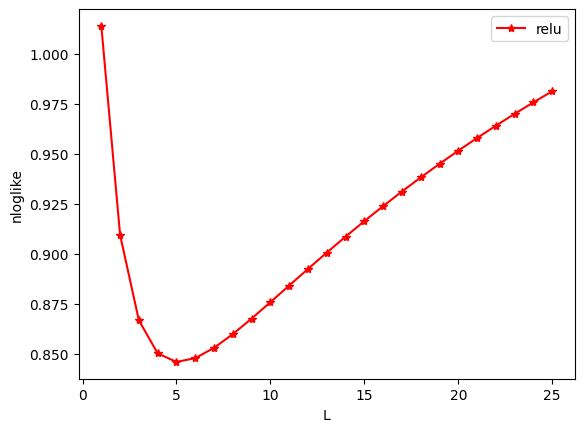

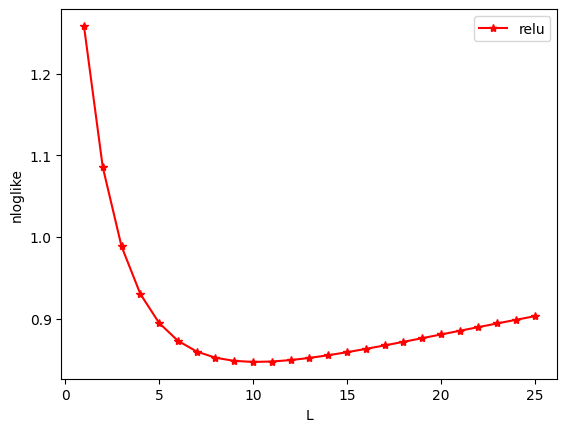

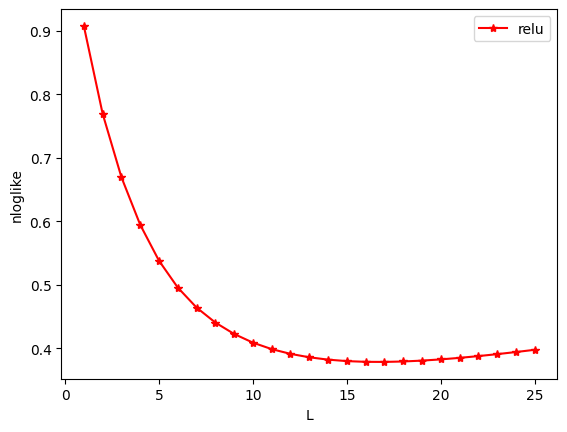

In [ ]:
args_scores = Namespace(
    nloglike = True,
    gmean = False,
    max = False,
    min = False,
    median = False,
    pvalue_comulative = False,
    backtesting = False
)

iteration_number = 0
total_iterations = len(grid_parameters_datasets['L'])*len(grid_parameters_datasets['n'])*len(grid_parameters_datasets['activation'])
grid_dataset_results = []
for architecture in get_architecture(grid_parameters_datasets):
  # print iteration_number
  iteration_number = iteration_number + 1
  print("{}/{}".format(iteration_number, total_iterations))

  dataset_handler = DatasetHandler()
  score_handler = Score_Handler()

  # Generator MLP Parameters
  L, n, activation, Cb, Cw = unpack_architecture(architecture)
  width_list = create_constant_widths_list(L, n)


  # Instantiate Generator
  mlp = MLP(L, width_list, activation, Cb, Cw, seed = L, use_bias = False, use_generator_init = True)

  # Create Dataset
  dataset, _= dataset_handler.create_dataset_from_MLP_given_input(mlp, input)
  var_y = dataset_handler.get_y_stddev()**2

  Cb = max(0, (var_y - 2/args.d)/(1+2*L/2))
  Cb_params_list = grid_parameters_predictors['Cb']
  Cb_params_list.pop(0)
  Cb_params_list.append(Cb)

  path = basepath + str(L) + "_" + activation + "/"
  gaussian_limit_df = create_or_load_gaussian_limit_for_each_predictors(path, args_datahandling, grid_parameters_predictors, input, scaled_input, use_scaled_input = True)


  mlpgenerator_datasetsimulation = MLPGeneratedDatasetSimulation(dataset_handler)
  if args_datahandling.save_dataset_on_cloud:
    # Save dataset description
    mlpgenerator_datasetsimulation.save_dataset_description_on_cloud(basepath)
    # Save dataset
    centered_dataset = dataset_handler.get_uncentered_dataset()
    path = basepath + str(L) + "_" + activation
    handle_dirs(path)
    filename = path + "/dataset.csv"
    with open(filename, 'w', encoding = 'utf-8-sig') as f:
      centered_dataset.to_csv(f, index = False)

  current_dataset_results = score_handler.compute_all_scores(dataset_handler, grid_parameters_predictors, gaussian_limit_df, args_scores)
  mlpgenerator_datasetsimulation.set_results(current_dataset_results)

  if args_datahandling.save_results_on_cloud:
    mlpgenerator_datasetsimulation.save_dataset_results_on_cloud(basepath)

  grid_dataset_results.append(mlpgenerator_datasetsimulation)

if args_datahandling.save_figures_on_cloud:
  lineplots(grid_dataset_results, basepath, args_scores)

### Descrizione Simulazione D
Generator: L = [5,10,15]\
Generator: activation = 'relu'\
Generator: Cw = 2\
Generator: No Bias

Predictor: L = [1,...,25]\
Predictor: activation = 'relu'\
Predictor: Cw = f(var_y) - scegliamo Cw in modo che la varianza della gaussiana limite tenda a var_y per L -> +inf\
Predictor: Cb = 1



In [ ]:
args_datahandling = Namespace(
    create_new_input = True,
    save_input_on_cloud = True,
    compute_gaussian_limit = True,
    save_gaussian_limit_on_cloud = True,
    save_dataset_on_cloud = True,
    save_results_on_cloud = True,
    save_figures_on_cloud = True
)

basepath = '/content/drive/MyDrive/Simulazioni/Simulazione_D/'

In [ ]:
grid_parameters_datasets = {'L' : [5,10,15], 'n':[50], 'activation':['relu'], 'Cb': [1], 'Cw': [1]}
grid_parameters_predictors = {'L' : np.arange(1,26,1), 'n':[5], 'activation':['relu'], 'Cb': [1], 'Cw': [2]}

In [ ]:
dataset_handler = DatasetHandler()
input = create_or_load_input(basepath, args_datahandling)



1/3
Cw:	1.6768885022276703
2/3
Cw:	1.6783137382632172
3/3
Cw:	0.16951189895871743


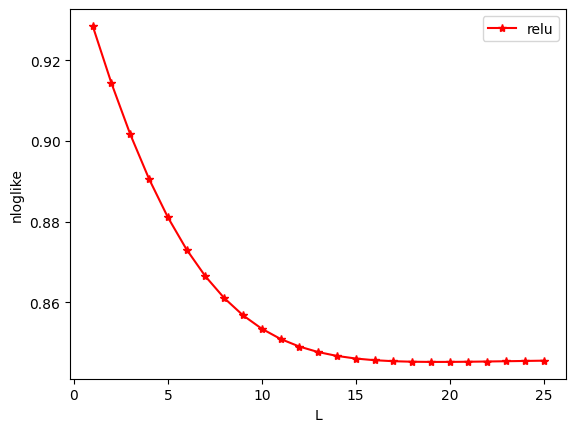

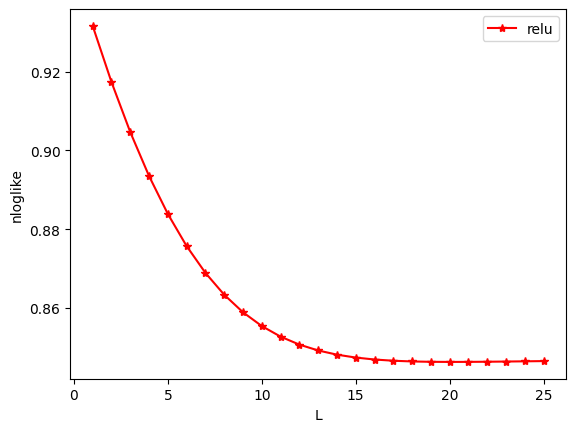

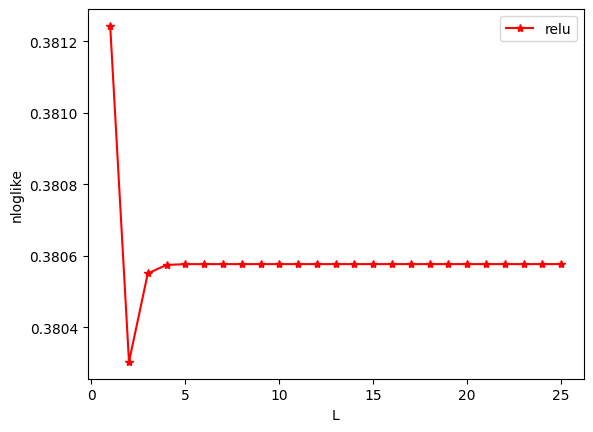

In [ ]:
args_scores = Namespace(
    nloglike = True,
    gmean = False,
    max = False,
    min = False,
    median = False,
    pvalue_comulative = False,
    backtesting = False
)

iteration_number = 0
total_iterations = len(grid_parameters_datasets['L'])*len(grid_parameters_datasets['n'])*len(grid_parameters_datasets['activation'])
grid_dataset_results = []
for architecture in get_architecture(grid_parameters_datasets):
  # print iteration_number
  iteration_number = iteration_number + 1
  print("{}/{}".format(iteration_number, total_iterations))

  dataset_handler = DatasetHandler()
  score_handler = Score_Handler()

  # Generator MLP Parameters
  L, n, activation, Cb, Cw = unpack_architecture(architecture)
  width_list = create_constant_widths_list(L, n)


  # Instantiate Generator
  mlp = MLP(L, width_list, activation, Cb, Cw, seed = L, use_bias = False, use_generator_init = True)

  # Create Dataset
  dataset, _= dataset_handler.create_dataset_from_MLP_given_input(mlp, input)
  var_y = dataset_handler.get_y_stddev()**2
  # Set Cw according to var_y
  Cw = compute_Cw_from_var_y(var_y, grid_parameters_predictors['Cb'][0])
  print("Cw:\t{}".format(Cw))
  Cw_params_list = grid_parameters_predictors['Cw']
  Cw_params_list.pop(0)
  Cw_params_list.append(Cw)

  path = basepath + str(L) + "_" + activation + "/"
  gaussian_limit_df = create_or_load_gaussian_limit_for_each_predictors(basepath+"", args_datahandling, grid_parameters_predictors, input)

  mlpgenerator_datasetsimulation = MLPGeneratedDatasetSimulation(dataset_handler)
  if args_datahandling.save_dataset_on_cloud:
    # Save dataset description
    mlpgenerator_datasetsimulation.save_dataset_description_on_cloud(basepath)
    # Save dataset
    centered_dataset = dataset_handler.get_uncentered_dataset()
    path = basepath + str(L) + "_" + activation
    handle_dirs(path)
    filename = path + "/dataset.csv"
    with open(filename, 'w', encoding = 'utf-8-sig') as f:
      centered_dataset.to_csv(f, index = False)

  current_dataset_results = score_handler.compute_all_scores(dataset_handler, grid_parameters_predictors, gaussian_limit_df, args_scores)
  mlpgenerator_datasetsimulation.set_results(current_dataset_results)

  if args_datahandling.save_results_on_cloud:
    mlpgenerator_datasetsimulation.save_dataset_results_on_cloud(basepath)

  grid_dataset_results.append(mlpgenerator_datasetsimulation)

if args_datahandling.save_figures_on_cloud:
  lineplots(grid_dataset_results, basepath, args_scores)

### Descrizione Simulazione E
Generator: L = [5,10,15]\
Generator: activation = 'relu'\
Generator: Cw = 2\
Generator: No Bias

Predictor: L = [1,...,40]\
Predictor: activation = 'relu'\
Predictor: Cw = 2\
Predictor: Cb = np.linspace(start = 0.05, stop = 2.5, num = 50)

GridSearch on L and Cb

In [ ]:
args_datahandling = Namespace(
    create_new_input = True,
    save_input_on_cloud = True,
    compute_gaussian_limit = True,
    save_gaussian_limit_on_cloud = True,
    save_dataset_on_cloud = True,
    save_results_on_cloud = True,
    save_sorted_results_on_cloud = True
)

basepath = '/content/drive/MyDrive/Simulazioni/Simulazione_E/'

In [ ]:
grid_parameters_datasets = {'L' : [5,10,15], 'n':[50], 'activation':['relu'], 'Cb': [1], 'Cw': [2]}
grid_parameters_predictors = {'L' : np.arange(1,41,1), 'n':[5], 'activation':['relu'], 'Cb': np.linspace(start = 0.05, stop = 2.5, num = 50), 'Cw': [2]}

In [ ]:
dataset_handler = DatasetHandler()
input = create_or_load_input(basepath, args_datahandling, radius = args.d)


In [ ]:
args_scores = Namespace(
    nloglike = True,
    gmean = False,
    max = False,
    min = False,
    median = False,
    pvalue_comulative = False,
    backtesting = False
)

iteration_number = 0
total_iterations = len(grid_parameters_datasets['L'])*len(grid_parameters_datasets['n'])*len(grid_parameters_datasets['activation'])
grid_dataset_results = []
for architecture in get_architecture(grid_parameters_datasets):
  # print iteration_number
  iteration_number = iteration_number + 1
  print("{}/{}".format(iteration_number, total_iterations))

  dataset_handler = DatasetHandler()
  score_handler = Score_Handler()

  # Generator MLP Parameters
  L, n, activation, Cb, Cw = unpack_architecture(architecture)
  width_list = create_constant_widths_list(L, n)


  # Instantiate Generator
  mlp = MLP(L, width_list, activation, Cb, Cw, seed = L, use_bias = False, use_generator_init = True)

  # Create Dataset
  dataset, _= dataset_handler.create_dataset_from_MLP_given_input(mlp, input)


  path = basepath + str(L) + "_" + activation + "/"
  gaussian_limit_df = create_or_load_gaussian_limit_for_each_predictors(path, args_datahandling, grid_parameters_predictors, input)


  mlpgenerator_datasetsimulation = MLPGeneratedDatasetSimulation(dataset_handler)
  if args_datahandling.save_dataset_on_cloud:
    # Save dataset description
    mlpgenerator_datasetsimulation.save_dataset_description_on_cloud(basepath)
    # Save dataset
    centered_dataset = dataset_handler.get_uncentered_dataset()
    path = basepath + str(L) + "_" + activation
    handle_dirs(path)
    filename = path + "/dataset.csv"
    with open(filename, 'w', encoding = 'utf-8-sig') as f:
      centered_dataset.to_csv(f, index = False)

  current_dataset_results = score_handler.compute_all_scores(dataset_handler, grid_parameters_predictors, gaussian_limit_df, args_scores)
  mlpgenerator_datasetsimulation.set_results(current_dataset_results)

  if args_datahandling.save_results_on_cloud:
    mlpgenerator_datasetsimulation.save_dataset_results_on_cloud(basepath)

  grid_dataset_results.append(mlpgenerator_datasetsimulation)

#if args_datahandling.save_figures_on_cloud:
#  lineplots(grid_dataset_results, basepath, args_scores)
if args_datahandling.save_sorted_results_on_cloud:
  for result_handler in grid_dataset_results:
    result_dataset = result_handler.result_dataset
    sorted_result_dataset = result_dataset.sort_values(by = ['nloglike'])             #NOTE: funziona solo con la nloglike
    L = result_handler.dataset_handler.mlp_generator_L
    activation = result_handler.dataset_handler.mlp_generator_activation
    Cb = result_handler.dataset_handler.mlp_generator_Cb
    Cw = result_handler.dataset_handler.mlp_generator_Cw
    path = basepath + str(L) + "_" + activation
    handle_dirs(path)
    filename = path + "/sorted_result.csv"
    with open(filename, 'w', encoding = 'utf-8-sig') as f:
      sorted_result_dataset.to_csv(f, index = False)


1/3


KeyboardInterrupt: ignored

In [ ]:
for result_handler in grid_dataset_results:
  result_dataset = result_handler.result_dataset
  sorted_result_dataset = result_dataset.sort_values(by = ['nloglike'])
  print(sorted_result_dataset)


   L activation    Cb  Cw  nloglike
0  1       relu  0.05   2  2.535501
2  2       relu  0.05   2  2.536361
1  1       relu  0.10   2  2.537220
4  3       relu  0.05   2  2.537220
3  2       relu  0.10   2  2.538939
5  3       relu  0.10   2  2.540656
   L activation    Cb  Cw  nloglike
0  1       relu  0.05   2  2.447456
2  2       relu  0.05   2  2.448610
1  1       relu  0.10   2  2.449762
4  3       relu  0.05   2  2.449762
3  2       relu  0.10   2  2.452057
5  3       relu  0.10   2  2.454343
   L activation    Cb  Cw  nloglike
0  1       relu  0.05   2  2.341741
2  2       relu  0.05   2  2.343222
1  1       relu  0.10   2  2.344697
4  3       relu  0.05   2  2.344697
3  2       relu  0.10   2  2.347635
5  3       relu  0.10   2  2.350554


### Descrizione Simulazione: Varianza Dataset 1
Generator: L = [5,10,15]\
Generator: activation = 'relu'\
Generator: Cw = 2\
Generator: No Bias

n_sample = 10000\
per_dataset_iterations = 10000


In [ ]:
args_datahandling = Namespace(
    create_new_input = True,
    save_input_on_cloud = True,
    save_var_y_on_cloud = True
)

args = Namespace(
    # Data and Path information
    n_sample = 10000,
    d = 10, #n_0
    n_L_plus_1 = 1,
    significance = 0.05, #pvalue
    percentage_interval = 0.2   #backtesting
)

basepath = '/content/drive/MyDrive/Simulazioni/Varianza_Dataset/1/'

In [ ]:
grid_parameters_datasets = {'L' : [5,10,15], 'n':[50], 'activation':['relu'], 'Cb': [1], 'Cw': [1]}
grid_parameters_predictors = {'L' : np.arange(1,26,1), 'n':[5], 'activation':['relu'], 'Cb': [1], 'Cw': [2]}

In [ ]:
dataset_handler = DatasetHandler()
input = create_or_load_input(basepath, args_datahandling)



provo a crearla


In [ ]:
per_dataset_iterations = 10000

iteration_number = 0
total_iterations = len(grid_parameters_datasets['L'])*len(grid_parameters_datasets['n'])*len(grid_parameters_datasets['activation'])
var_y_arrays = []
start_seeds = [10000, 20000, 30000]
for architecture in get_architecture(grid_parameters_datasets):
  # print iteration_number
  iteration_number = iteration_number + 1
  print("{}/{}".format(iteration_number, total_iterations))

  dataset_handler = DatasetHandler()
  score_handler = Score_Handler()

  # Generator MLP Parameters
  L, n, activation, Cb, Cw = unpack_architecture(architecture)
  width_list = create_constant_widths_list(L, n)
  start_seed = start_seeds[iteration_number-1]
  var_y_list = []
  for index in range(per_dataset_iterations):
    seed = start_seed + index
    # Instantiate Generator
    mlp = MLP(L, width_list, activation, Cb, Cw, seed = seed, use_bias = False, use_generator_init = True)

    # Create Dataset
    dataset, _= dataset_handler.create_dataset_from_MLP_given_input(mlp, input)
    var_y = dataset_handler.get_y_stddev()**2
    var_y_list.append(var_y)
  # Set Cw according to var_y

  var_y_array = np.array(var_y_list)
  df = pd.DataFrame.from_dict({'var_y' : var_y_array})

  if args_datahandling.save_var_y_on_cloud:
    path = basepath + str(L) + "_" + activation
    handle_dirs(path)
    filename = path + "/var_y.csv"
    with open(filename, 'w', encoding = 'utf-8-sig') as f:
      df.to_csv(f, index = False)

  var_y_arrays.append(var_y_array)
  print("L = {}\tmean(var_y) = {}\tvar(var_y) = {}".format(L, np.mean(var_y_array), np.var(var_y_array)))

1/3
L = 5	mean(var_y) = 8.327674318262057	var(var_y) = 28.476159254213197
2/3
provo a crearla
L = 10	mean(var_y) = 5.141941549206249	var(var_y) = 37.20826121552719
3/3
provo a crearla
L = 15	mean(var_y) = 4.340239736613816	var(var_y) = 85.20467045615341


In [ ]:
print("1/3\nL = 5	mean(var_y) = 8.327674318262057	var(var_y) = 28.476159254213197\n2/3\nprovo a crearla\nL = 10	mean(var_y) = 5.141941549206249	var(var_y) = 37.20826121552719\n3/3\nprovo a crearla\nL = 15	mean(var_y) = 4.340239736613816	var(var_y) = 85.20467045615341")

1/3
L = 5	mean(var_y) = 8.327674318262057	var(var_y) = 28.476159254213197
2/3
provo a crearla
L = 10	mean(var_y) = 5.141941549206249	var(var_y) = 37.20826121552719
3/3
provo a crearla
L = 15	mean(var_y) = 4.340239736613816	var(var_y) = 85.20467045615341


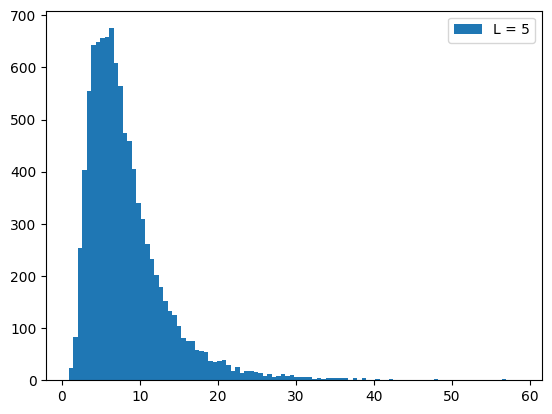

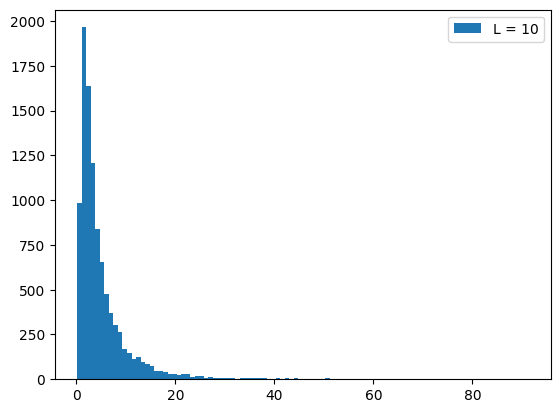

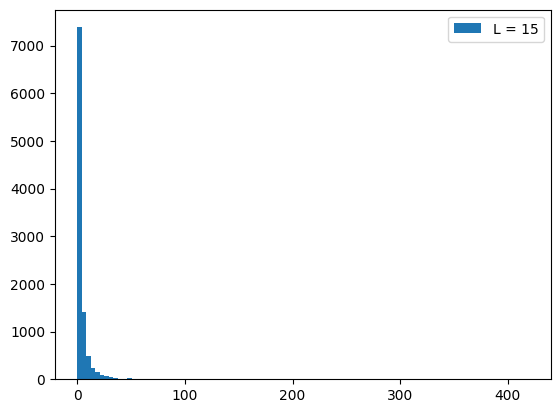

In [ ]:
dict_L_vars = {}
for architecture in get_architecture(grid_parameters_datasets):
  L, n, activation, Cb, Cw = unpack_architecture(architecture)
  path = basepath + str(L) + "_" + activation
  filename = path + "/var_y.csv"
  with open(filename, 'r', encoding = 'utf-8-sig') as f:
    df = pd.read_csv(f)
    dict_L_vars[L] = df
  fig = plt.figure()
  plt.hist(df['var_y'], bins = 100, label = "L = " + str(L))
  plt.legend()
  plt.show()


### Descrizione Simulazione: Varianza Dataset 2
Generator: L = [5,10,15]\
Generator: activation = 'relu'\
Generator: Cw = 2\
Generator: No Bias

n_sample = 2000\
per_dataset_iterations = 5000


In [ ]:
args_datahandling = Namespace(
    create_new_input = True,
    save_input_on_cloud = True,
    save_var_y_on_cloud = True
)

args = Namespace(
    # Data and Path information
    n_sample = 2000,
    d = 10, #n_0
    n_L_plus_1 = 1,
    significance = 0.05, #pvalue
    percentage_interval = 0.2   #backtesting
)

basepath = '/content/drive/MyDrive/Simulazioni/Varianza_Dataset/2/'

In [ ]:
grid_parameters_datasets = {'L' : [5,10,15], 'n':[50], 'activation':['relu'], 'Cb': [1], 'Cw': [1]}
grid_parameters_predictors = {'L' : np.arange(1,26,1), 'n':[5], 'activation':['relu'], 'Cb': [1], 'Cw': [2]}

In [ ]:
dataset_handler = DatasetHandler()
input = create_or_load_input(basepath, args_datahandling)



In [ ]:
per_dataset_iterations = 5000

iteration_number = 0
total_iterations = len(grid_parameters_datasets['L'])*len(grid_parameters_datasets['n'])*len(grid_parameters_datasets['activation'])
var_y_arrays = []
start_seeds = [10000, 20000, 30000]
for architecture in get_architecture(grid_parameters_datasets):
  # print iteration_number
  iteration_number = iteration_number + 1
  print("{}/{}".format(iteration_number, total_iterations))

  dataset_handler = DatasetHandler()
  score_handler = Score_Handler()

  # Generator MLP Parameters
  L, n, activation, Cb, Cw = unpack_architecture(architecture)
  width_list = create_constant_widths_list(L, n)
  start_seed = start_seeds[iteration_number-1]
  var_y_list = []
  for index in range(per_dataset_iterations):
    seed = start_seed + index
    # Instantiate Generator
    mlp = MLP(L, width_list, activation, Cb, Cw, seed = seed, use_bias = False, use_generator_init = True)

    # Create Dataset
    dataset, _= dataset_handler.create_dataset_from_MLP_given_input(mlp, input)
    var_y = dataset_handler.get_y_stddev()**2
    var_y_list.append(var_y)
  # Set Cw according to var_y

  var_y_array = np.array(var_y_list)
  df = pd.DataFrame.from_dict({'var_y' : var_y_array})

  if args_datahandling.save_var_y_on_cloud:
    path = basepath + str(L) + "_" + activation
    handle_dirs(path)
    filename = path + "/var_y.csv"
    with open(filename, 'w', encoding = 'utf-8-sig') as f:
      df.to_csv(f, index = False)

  var_y_arrays.append(var_y_array)
  print("L = {}\tmean(var_y) = {}\tvar(var_y) = {}".format(L, np.mean(var_y_array), np.var(var_y_array)))

1/3
L = 5	mean(var_y) = 8.261906181126458	var(var_y) = 28.573580369435884
2/3
L = 10	mean(var_y) = 5.264259940123609	var(var_y) = 40.767768172975636
3/3
L = 15	mean(var_y) = 4.343845659124134	var(var_y) = 103.85593254797092


In [ ]:
print("1/3\nL = 5	mean(var_y) = 8.261906181126458	var(var_y) = 28.573580369435884\n2/3\nL = 10	mean(var_y) = 5.264259940123609	var(var_y) = 40.767768172975636\n3/3\nL = 15	mean(var_y) = 4.343845659124134	var(var_y) = 103.85593254797092")

1/3
L = 5	mean(var_y) = 8.261906181126458	var(var_y) = 28.573580369435884
2/3
L = 10	mean(var_y) = 5.264259940123609	var(var_y) = 40.767768172975636
3/3
L = 15	mean(var_y) = 4.343845659124134	var(var_y) = 103.85593254797092


### Descrizione Simulazione: Varianza Dataset 3
Generator: L = [5,10,15]\
Generator: activation = 'relu'\
Generator: Cw = 2\
Generator: No Bias

n_sample = 2000\
per_dataset_iterations = 2000



In [ ]:
args_datahandling = Namespace(
    create_new_input = True,
    save_input_on_cloud = True,
    save_var_y_on_cloud = True
)

args = Namespace(
    # Data and Path information
    n_sample = 2000,
    d = 10, #n_0
    n_L_plus_1 = 1,
    significance = 0.05, #pvalue
    percentage_interval = 0.2   #backtesting
)

basepath = '/content/drive/MyDrive/Simulazioni/Varianza_Dataset/3/'

In [ ]:
grid_parameters_datasets = {'L' : [5,10,15], 'n':[50], 'activation':['relu'], 'Cb': [1], 'Cw': [1]}
grid_parameters_predictors = {'L' : np.arange(1,26,1), 'n':[5], 'activation':['relu'], 'Cb': [1], 'Cw': [2]}

In [ ]:
dataset_handler = DatasetHandler()
input = create_or_load_input(basepath, args_datahandling)



provo a crearla


In [ ]:
per_dataset_iterations = 2000

iteration_number = 0
total_iterations = len(grid_parameters_datasets['L'])*len(grid_parameters_datasets['n'])*len(grid_parameters_datasets['activation'])
var_y_arrays = []
start_seeds = [10000, 20000, 30000]
for architecture in get_architecture(grid_parameters_datasets):
  # print iteration_number
  iteration_number = iteration_number + 1
  print("{}/{}".format(iteration_number, total_iterations))

  dataset_handler = DatasetHandler()
  score_handler = Score_Handler()

  # Generator MLP Parameters
  L, n, activation, Cb, Cw = unpack_architecture(architecture)
  width_list = create_constant_widths_list(L, n)
  start_seed = start_seeds[iteration_number-1]
  var_y_list = []
  for index in range(per_dataset_iterations):
    seed = start_seed + index
    # Instantiate Generator
    mlp = MLP(L, width_list, activation, Cb, Cw, seed = seed, use_bias = False, use_generator_init = True)

    # Create Dataset
    dataset, _= dataset_handler.create_dataset_from_MLP_given_input(mlp, input)
    var_y = dataset_handler.get_y_stddev()**2
    var_y_list.append(var_y)
  # Set Cw according to var_y

  var_y_array = np.array(var_y_list)
  df = pd.DataFrame.from_dict({'var_y' : var_y_array})

  if args_datahandling.save_var_y_on_cloud:
    path = basepath + str(L) + "_" + activation
    handle_dirs(path)
    filename = path + "/var_y.csv"
    with open(filename, 'w', encoding = 'utf-8-sig') as f:
      df.to_csv(f, index = False)

  var_y_arrays.append(var_y_array)
  print("L = {}\tmean(var_y) = {}\tvar(var_y) = {}".format(L, np.mean(var_y_array), np.var(var_y_array)))

In [ ]:
print("1/3\nprovo a crearla\nL = 5	mean(var_y) = 8.315991442223432	var(var_y) = 28.654603649061833\n2/3\nprovo a crearla\nL = 10	mean(var_y) = 5.362004435866927	var(var_y) = 49.01784445765025\n3/3\nprovo a crearla\nL = 15	mean(var_y) = 4.39766268005835	var(var_y) = 161.43436090497292")

1/3
provo a crearla
L = 5	mean(var_y) = 8.315991442223432	var(var_y) = 28.654603649061833
2/3
provo a crearla
L = 10	mean(var_y) = 5.362004435866927	var(var_y) = 49.01784445765025
3/3
provo a crearla
L = 15	mean(var_y) = 4.39766268005835	var(var_y) = 161.43436090497292
